In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

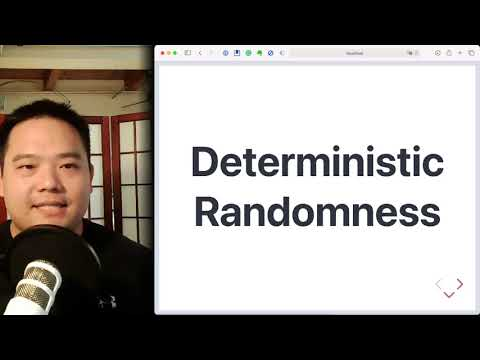

In [2]:
from IPython.display import YouTubeVideo, display

YouTubeVideo("3qnX1OXQ3Ws")

# Deterministic Randomness

In this section, we'll explore how to create programs 
that use random number generation in a fashion that is fully deterministic.
If that sounds weird to you, fret not: 
it sounded weird to me too when I first started using random numbers.
My goal here is to demystify this foundational piece for you.

## Random number generation before JAX

Before JAX came along, we used NumPy's stateful random number generation system.
Let's quickly recap how it works.

In [3]:
import numpy as onp  # original numpy

Let's draw a random number from a Gaussian in NumPy.

In [4]:
onp.random.seed(42)

In [5]:
a = onp.random.normal()
a

0.4967141530112327

And for good measure, let's draw another one.

In [6]:
b = onp.random.normal()
b

-0.13826430117118466

This is intuitive behaviour,
because we expect that each time we call on a random number generator,
we should get back a different number from before.

However, this behaviour is problematic when we are trying to debug programs.
When debugging, one desirable property is determinism.
Executing the same line of code twice _should_ produce exactly the same result.
Otherwise, debugging what happens at that particular line would be extremely difficult.
The core problem here is that stochastically,
we might hit a setting where we encounter an error in our program,
and we are unable to reproduce it because we are relying on
a random number generator that relies on global state,
and hence that doesn't behave in a _fully_ controllable fashion.

I don't know about you, but if I am going to encounter problems,
I'd like to encounter them _reliably_!

## Random number generation with JAX

How then can we get "the best of both worlds": random number generation that is controllable?

### Explicit PRNGKeys control random number generation

The way that JAX's developers went about doing this
is to use pseudo-random number generators
that require explicit passing in of a pseudo-random number generation key,
rather than relying on a global state being set.
Each unique key will deterministically give a unique drawn value explicitly.
Let's see that in action:

In [7]:
from jax import random

key = random.PRNGKey(42)

a = random.normal(key=key)
a

DeviceArray(-0.18471184, dtype=float32)

To show you that passing in the same key gives us the same values as before:

In [8]:
b = random.normal(key=key)
b

Buffer(-0.18471184, dtype=float32)

That should already be a stark difference from what you're used to with vanilla NumPy,
and this is one key crucial difference between JAX's random module and NumPy's random module.
Everything else about the API is very similar,
but this is a key difference, and for good reason -- 
this should hint to you the idea that we can have explicit reproducibility,
rather than merely implicit,
over our stochastic programs within the same session.

### Splitting keys to generate new draws

How, then, do we get a new draw from JAX?
Well, we can either create a new key manually,
or we can programmatically split the key into two,
and use one of the newly split keys to generate a new random number. Let's see that in action:

In [9]:
k1, k2 = random.split(key)
c = random.normal(key=k2)
c

Buffer(1.3694694, dtype=float32)

In [10]:
k3, k4, k5 = random.split(k2, num=3)
d = random.normal(key=k3)
d

Buffer(0.04692494, dtype=float32)

### Generating multiple draws from a Gaussian, two ways

To show you how we can combine random keys together with `vmap`, here's two ways we can generate random draws from a Normal distribution.

The first way is to split the key into K (say, 20) pieces and then vmap `random.normal` over the split keys.

In [11]:
from jax import vmap
key = random.PRNGKey(44)
ks = random.split(key, 20)  # we want to generate 20 draws
draws = vmap(random.normal)(ks)
draws

DeviceArray([-0.2531793 , -0.51041234,  0.16341999, -0.03866951,
              0.85914546,  0.9833364 , -0.6223309 ,  0.5909158 ,
              1.4065154 , -0.2537227 , -0.20608927,  1.1317427 ,
             -0.92549866,  1.035201  ,  1.9401319 ,  0.34215063,
              1.6209698 ,  0.49294266,  0.5414663 ,  0.10813037],            dtype=float32)

Of course, the second way is to simply specify the shape of the draws.

In [12]:
random.normal(key, shape=(20,))

DeviceArray([ 0.39843866, -2.626297  , -0.6032239 , -2.081308  ,
              0.00854138,  0.76385975,  0.79169536,  1.0279497 ,
              0.5869708 , -0.87620246,  1.3288299 ,  1.7267487 ,
              0.786439  , -2.752421  ,  1.0341094 , -0.2926419 ,
             -0.21061882, -1.1115512 , -0.96723807,  0.12201323],            dtype=float32)

By splitting the key into two, three, or even 1000 parts, we can get new keys that are derived from a parent key that generate different random numbers from the same random number generating function.

Let's explore how we can use this in the generation of a Gaussian random walk.

## Example: Simulating a Gaussian random walk

A Gaussian random walk is one where we start at a point that is drawn from a Gaussian,
and then we draw another point from a Gausian using the first point as the starting Gaussian point.
Does that loop structure sound familiar? 
Well... yeah, it sounds like a classic `lax.scan` setup!

Here's how we might set it up.

Firstly, JAX's `random.normal` function doesn't allow us to specify the location and scale,
and only gives us a draw from a unit Gaussian.
We can work around this, because any unit Gaussian draw can be shifted and scaled to a $N(\mu, \sigma)$
by multiplying the draw by $\sigma$ and adding $\mu$. 

Knowing this, let's see how we can write a Gaussian random walk using JAX's idioms, building up from a vanilla Python implementation.

### Vanilla Python implementation

For those who might not be too familiar with Gaussian random walks,
here is an annotated version in vanilla Python code
(plus some use of the JAX PRNGKey system added in).

In [13]:
num_timesteps = 100

mu = 0.0  # starting mean.
observations = [mu]

key = random.PRNGKey(44)
# Split the key num_timesteps number of times
keys = random.split(key, num_timesteps)

# Gaussian Random Walk goes here
for k in keys:
    mu = mu + random.normal(k)
    observations.append(mu)

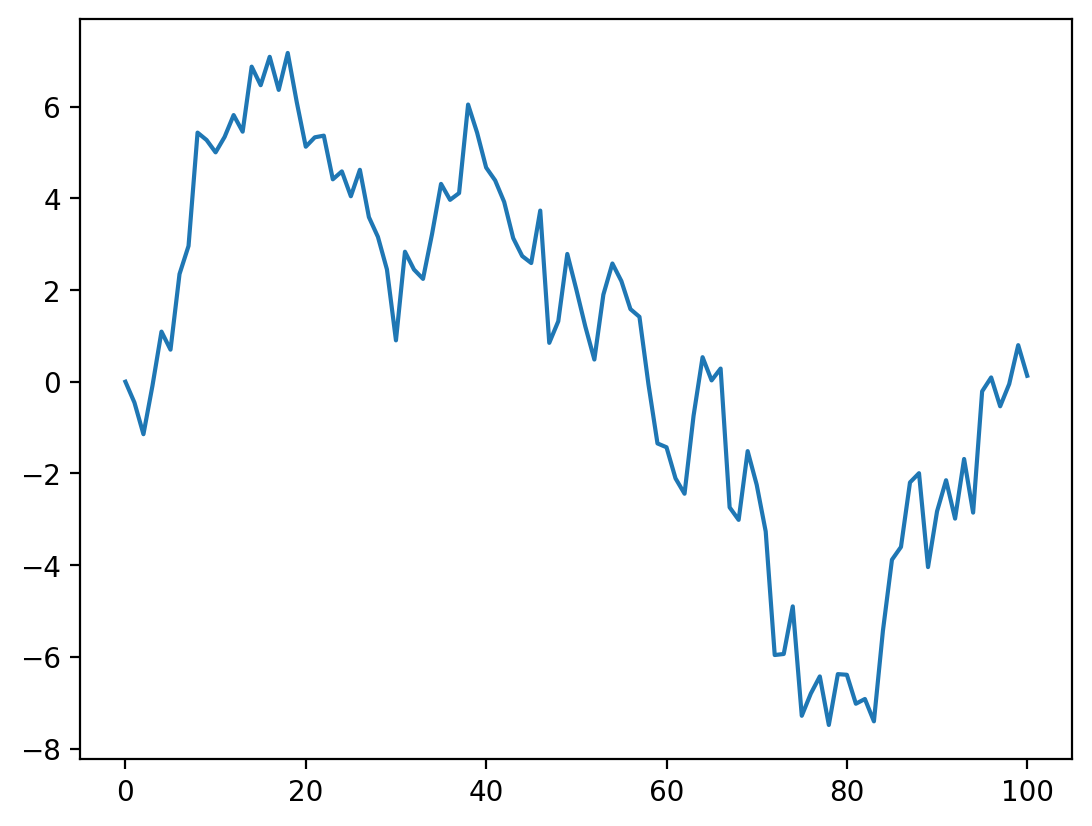

In [15]:
import matplotlib.pyplot as plt

plt.plot(observations);

### Implementation using JAX

Now, let's see how we can write a Gaussian random walk
using `lax.scan`.
The strategy we'll go for is as follows:

1. We'll instantiate an array of PRNG keys.
2. We'll then scan a function across the PRNG keys.
3. We'll finally collect the observations together.

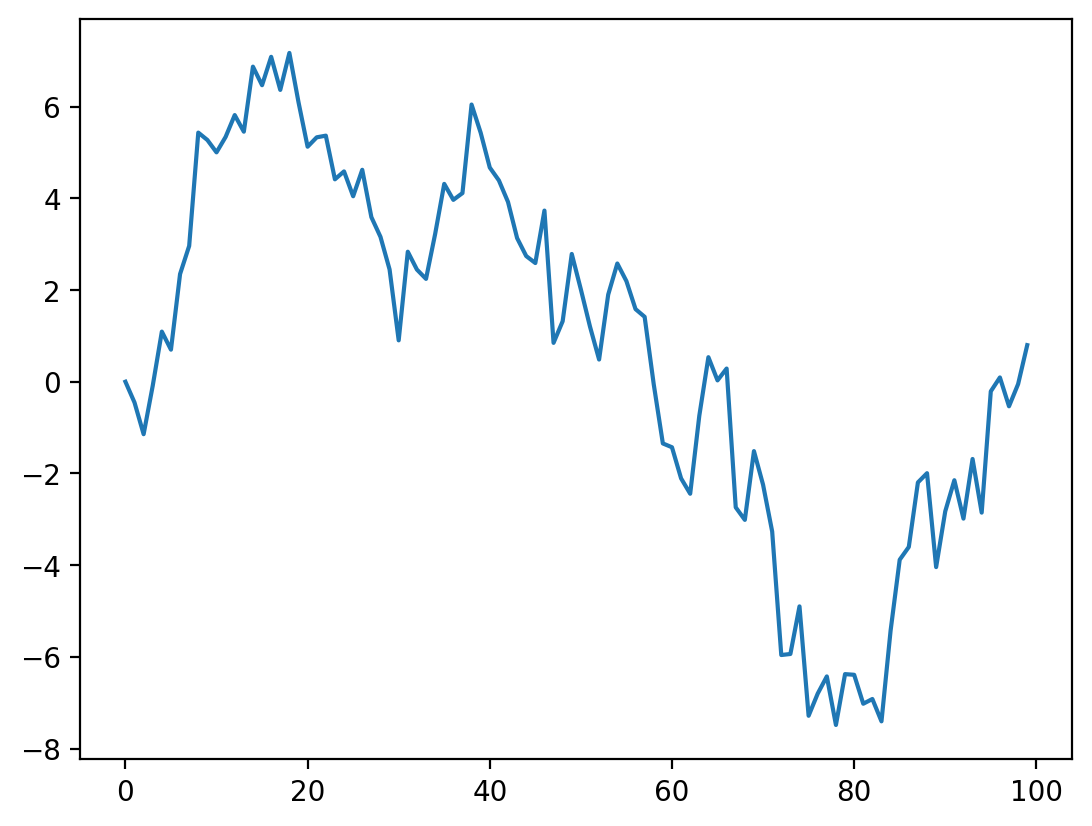

In [16]:
from jax import lax

def new_draw(prev_val, key):
    new = prev_val + random.normal(key)
    return new, prev_val


final, draws = lax.scan(new_draw, 0.0, keys)
plt.plot(draws);

Looks like we did it!
Definitely looks like a proper Gaussian random walk to me. 
Let's encapsulate the code inside a function
that gives us _one_ random walk draw,
as I will show you how next to generate multiple random walk draws.

In [19]:
def grw_draw(key, num_steps):
    keys = random.split(key, num_steps)
    # call previous function
    final, draws = lax.scan(new_draw, 0.0, keys)
    return final, draws

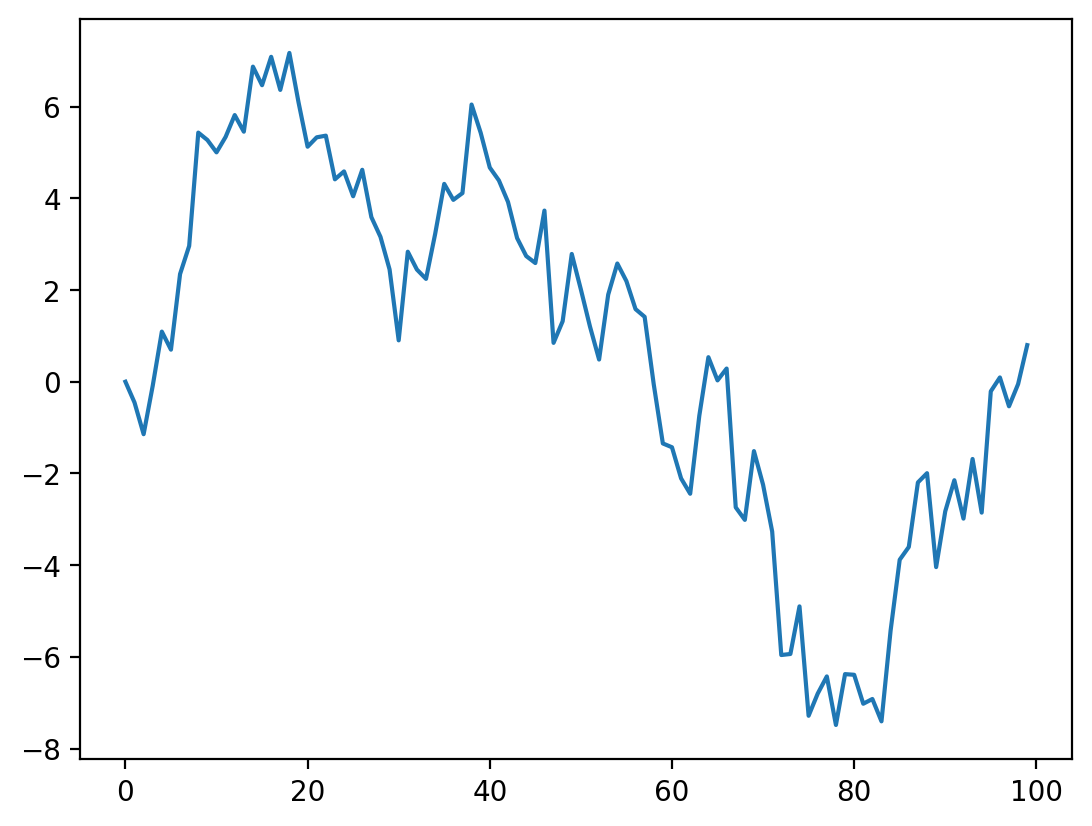

In [20]:
final, draw = grw_draw(key, num_steps=100)
plt.plot(draw);

## A note on reproducibility

Now, note how if you were to re-run the entire program from top-to-bottom again, 
you would get _exactly the same plot_. 
This is what we might call _strictly reproducible_.
Traditional array programs are not always written in a strictly reproducible way;
the sloppy programmer would set a global state at the top of a notebook and then call it a day.

By contrast, with JAX's random number generation paradigm, 
any random number generation program is 100% reproducible, 
down to the level of the exact sequence of random number draws, 
as long as the seed(s) controlling the program are 100% identical.
Because JAX's stochastic programs _always_ require an explicit key to be provided,
as long as you write your stochastic programs to depend on keys passed into it,
rather than keys instantiated from within it,
any errors you get can be fully reproduced by passing in exactly the same key.

When an error shows up in a program, 
as long as its stochastic components are controlled by explicitly passed in seeds,
that error is 100% reproducible. 
For those who have tried working with stochastic programs before,
this is an extremely desirable property,
as it means we gain the ability to reliably debug our program --
absolutely crucial especially when it comes to working with probabilistic models.

Also notice how we finally wrote our first productive for-loop --
but it was only to plot something, not for some form of calculations :).

## Exercise 1: Brownian motion on a grid

In this exercise, the goal is to simulate the random walk of a single particle on a 2D grid.
The particle's (x, y) position can be represented by a vector of length 2.
At each time step, the particle moves either in the x- or y- direction,
and when it moves, it either goes +1 or -1 along that axis.
Here is the NumPy + Python loopy equivalent that you'll be simulating.

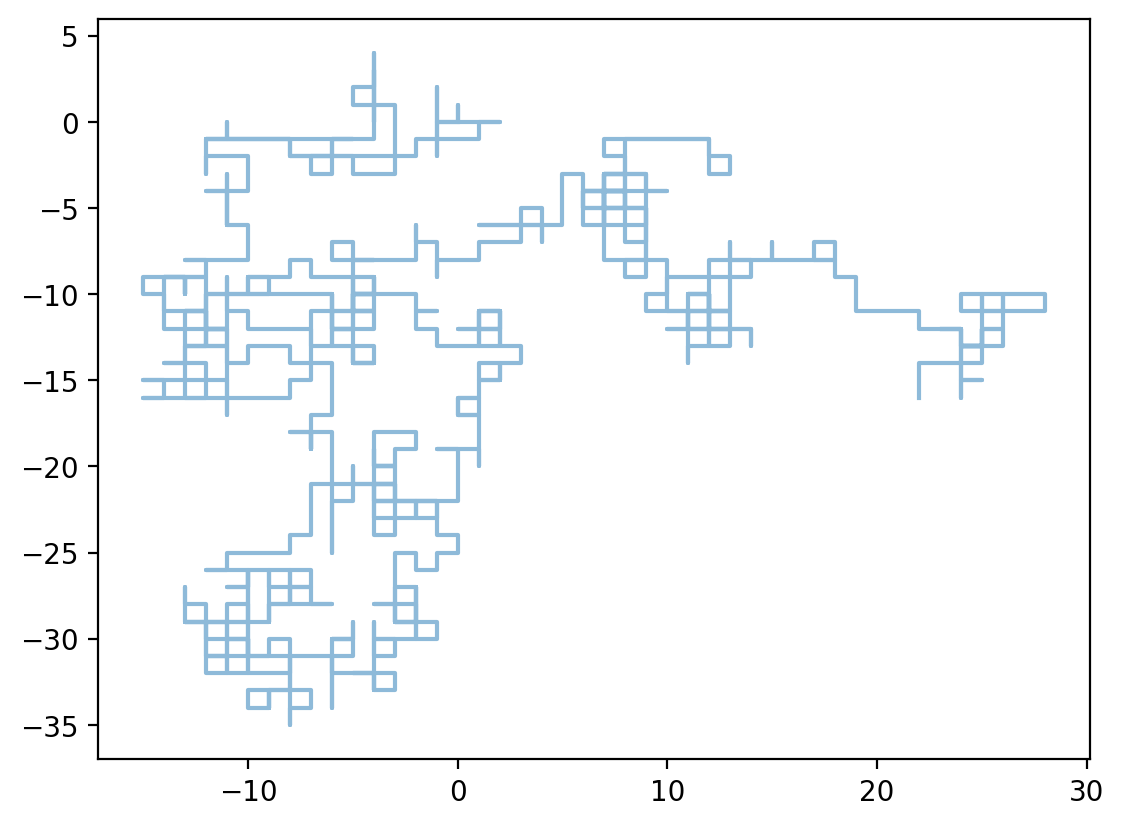

In [22]:
import jax.numpy as np

starting_position = onp.array([0, 0])
n_steps = 1000

positions = [starting_position]
keys = random.split(key, n_steps)

for k in keys:
    k1, k2 = random.split(k)
    axis = random.choice(k1, np.array([0, 1]))
    direction = random.choice(k2, np.array([-1, 1]))
    x, y = positions[-1]
    if axis == 0:
        x += direction
    else:
        y += direction
    new_position = np.array([x, y])
    positions.append(new_position)
positions = np.stack(positions)
plt.plot(positions[:, 0], positions[:, 1], alpha=0.5);

Your challenge is to replicate the brownian motion on a grid using JAX's random module.
Some hints that may help you get started include:

1. JAX arrays are immutable, so you definitely cannot do `arr[:, 0] += 1`.
2. `random.permutation` can be used to identify which axis to move.
3. `random.choice` can be used to identify which direction to go in.
4. Together, the axis to move in and the direction to proceed can give you something to loop over...
5. ...but without looping explicitly :), for which you have all of the tricks in the book.

In [39]:
keys[:, 1].reshape(-1).shape

(1000,)

In [40]:
keys.shape

(1000, 2)

In [43]:
ks = vmap(random.split)(keys)
ks.shape

(1000, 2, 2)

In [54]:
from functools import partial
direction = vmap(partial(random.choice, a=np.array([-1, 1])))(ks[:, 1])
axes = vmap(partial(random.permutation, x=np.array([0, 1])))(ks[:, 0])
direction.shape

(1000,)

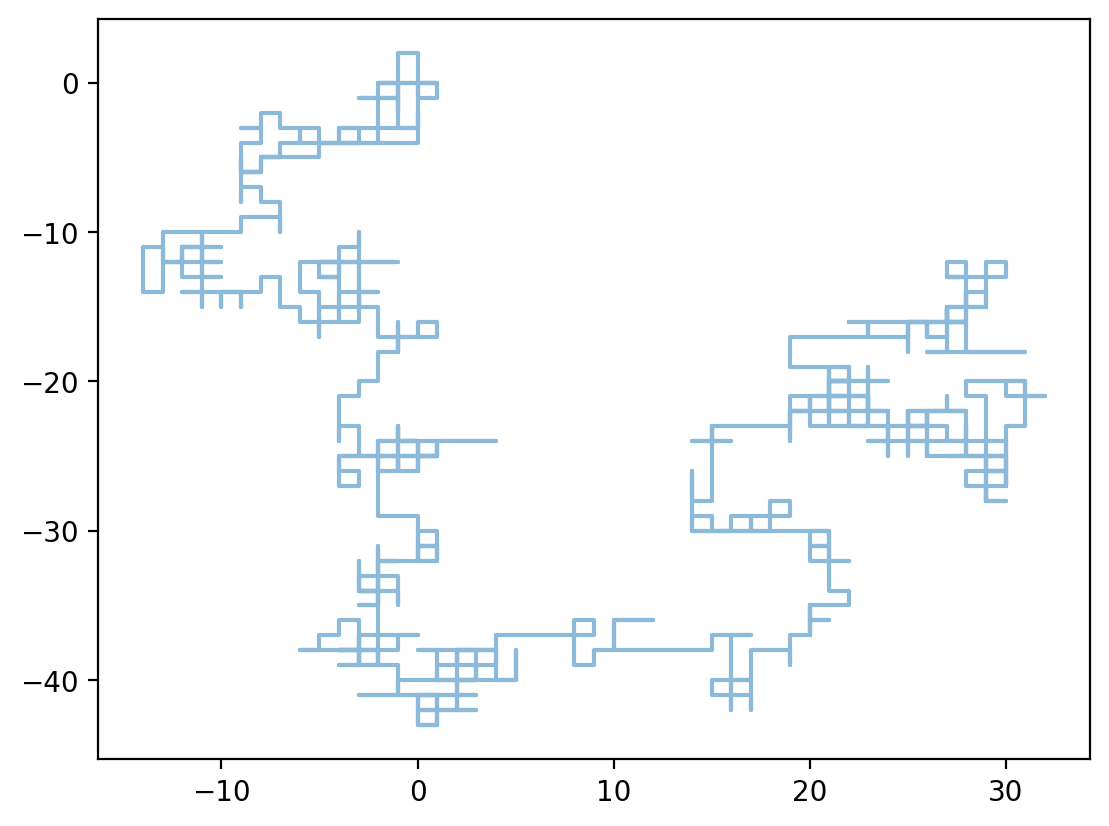

In [57]:
def randomness_ex_1(keys, starting_position):
    # need to split keys this way - creates (1000, 2, 2) vector of keys
    ks = vmap(random.split)(keys)

    # axis w. 1 is axis to move across for step -> shape is (1000, 2)
    axes = vmap(partial(random.permutation, x=np.array([0, 1])))(ks[:, 0])

    # choose positive or negative direction -> shape is (1000,)
    direction = vmap(partial(random.choice, a=np.array([-1, 1])))(ks[:, 1])

    # make direction a (1000, 1) vector to get (1000, 2) vector of moves
    change_vectors = axes * np.reshape(direction, (-1, 1))

    def step(prev_pos, change_vec):
        new_pos = prev_pos + change_vec

        # new_pos is both appended to final vec + is accumulating
        return new_pos, new_pos
    final, history = lax.scan(step, init=starting_position, xs=change_vectors)
    return final, history


keys = random.split(key, n_steps)

final, history = randomness_ex_1(keys, starting_position)
plt.plot(history[:, 0], history[:, 1], alpha=0.5);

## Exercise 2: Stochastic stick breaking

In the previous notebook, we introduced you to the stick-breaking process,
and we asked you to write it in a non-stochastic fashion.
We're now going to have you write it using a stochastic draw.

To do so, however, you need to be familiar with the [Beta distribution][betadist],
which models a random draw from the interval $x \in (0, 1)$.

[betadist]: https://en.wikipedia.org/wiki/Beta_distribution

Here is how you can draw numbers from the Beta distribution:

In [ ]:
betadraw = random.beta(key, a=1, b=2)
betadraw

Now, I'm going to show you the NumPy + Python equivalent of the _real_ (i.e. stochastic) stick-breaking process:

In [ ]:
import jax.numpy as np

num_breaks = 30
keys = random.split(key, num_breaks)
concentration = 5

sticks = []
stick_length = 1.0
for k in keys:
    breaking_fraction = random.beta(k, a=1, b=concentration)
    stick = stick_length * breaking_fraction
    sticks.append(stick)
    stick_length = stick_length - stick
result = np.array(sticks)
result

Now, your task is to implement it using `lax.scan`.

In [ ]:
def randomness_ex_2(key, num_breaks, concentration: float):
    # Your answer here!
    pass


# Comment out the import to test your answer!
from dl_workshop.jax_idioms import randomness_ex_2

final, sticks = randomness_ex_2(key, num_breaks, concentration)
assert np.allclose(sticks, result)

## Exercise 3: Multiple GRWs

Now, what if we wanted to generate multiple realizations of the Gaussian random walk? 
Does this sound familiar? 
If so... yeah, it's a vanilla for-loop, which directly brings us to `vmap`!
And that's what we're going to try to implement in this exercise.

In [ ]:
from functools import partial

from jax import vmap

The key idea here is to `vmap` the `grw_draw` function across multiple PRNGKeys.
That way, you can avoid doing a for-loop, which is the goal of this exercise too.
You get to decide how many realizations of the GRW you'd like to create.

In [ ]:

def randomness_ex_3(key, num_realizations=20, grw_draw=grw_draw):
    # Your answer here
    pass

from dl_workshop.jax_idioms import randomness_ex_3

final, trajectories = randomness_ex_3(key, num_realizations=20, grw_draw=grw_draw)

In [ ]:
trajectories.shape

We did it! We have 20 trajectories of a 1000-step Gaussian random walk. 
Notice also how the program is structured very nicely: 
Each layer of abstraction in the program corresponds to a new axis dimension along which we are working. 
The onion layering of the program has very _natural_ structure for the problem at hand.
Effectively, we have planned out, or perhaps staged out, our computation using Python
before actually executing it.

Let's visualize the trajectories to make sure they are really GRW-like.

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()

for trajectory in trajectories[0:20]:
    ax.plot(trajectory)
sns.despine()